In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy import linalg
# pip install SciencePlots
# don't delete the import because it's the style
import scienceplots

%matplotlib widget

In [2]:
plt.style.use("science")

In [3]:
def norm(psi, mesh_size):
    return np.sqrt(np.dot(np.conj(psi), psi) * mesh_size)

In [4]:
def rho(psi):
    return (np.conj(psi) * psi).real

In [5]:
def laplacian(n):
    """∇·∇運算子"""
    dx = x[1] - x[0]  # 微小變化量
    return (-2 * np.diag(np.ones(n, np.float32), 0)
            + np.diag(np.ones((n - 1), np.float32), 1)
            + np.diag(np.ones((n - 1), np.float32), -1)) / (dx ** 2)

In [6]:
mass = 1
hbar = 1
xmin = 0
xmax = 100
ninterval = 1600
show_density = True

x = np.linspace(xmin, xmax, ninterval)
peak_shape = "square"

Lap = laplacian(ninterval)

In [29]:
def barrier(avg_e=2.06, shape="square"):
    L = x[-1] - x[0]  # 總距離
    if shape == 'square':
        # __|▔|__
        pot = (np.heaviside(x - 0.45 * L, 0.5) - np.heaviside(x - 0.55 * L, 0.5)) * avg_e
    elif shape == 'heaviside':
        # ___|▔▔▔
        pot = np.heaviside(x - 0.5 * L, 0.5) * avg_e
    elif shape == 'well':
        # ▔▔|_|▔▔
        pot = (np.heaviside(x - 0.55 * L, 0.5) - np.heaviside(x - 0.45 * L, 0.5)) * avg_e
    return pot

In [23]:
U = np.diag(barrier(shape=peak_shape), 0)
H = - hbar ** 2 / (2 * mass) * Lap + U

In [9]:
def wave_packet(ax, kmu=2, ka=20):
    """kmu: peak momentum
       ka: momentum width parameter
       return the Fourier transformation of
              exp(-ka * (k - kmu)^2) * exp(-6j k^2)
    """
    L = ax[-1] - ax[0]  # x的最後項 - x的最前項
    dk = 2 * np.pi / L
    N = len(ax)
    k = np.linspace(0, N * dk, N)

    psi_k = np.exp(-ka * (k - kmu) ** 2 + -6j * k ** 2)  # Ψₖ

    temp = np.dot(np.diag(k * k, 0) / (2 * mass), psi_k)
    avg_e = np.dot(np.conjugate(psi_k), temp) * dk
    avg_e = avg_e / norm(psi_k, dk) ** 2

    psi = np.fft.ifft(psi_k)
    dx = x[1] - x[0]
    psi = psi / norm(psi, dx)
    return psi, avg_e

In [10]:
def evolve(tfinal=30.0, nt=400):
    t = np.linspace(0, tfinal, nt)
    dt = t[1] - t[0]
    Ut = linalg.expm(-1j * H * dt / hbar)
    #print(f'{Ut=}')
    psi_list = []
    rho_list = []

    psi = np.copy(wave)
    psi_list.append(psi)
    rho_list.append(rho(psi))

    for i in range(nt):
        psi = np.dot(Ut, psi)
        psi_list.append(psi)
        rho_list.append(rho(psi))

    return t, psi_list, rho_list

In [11]:
wave, avgE = wave_packet(x, kmu=2, ka=20)

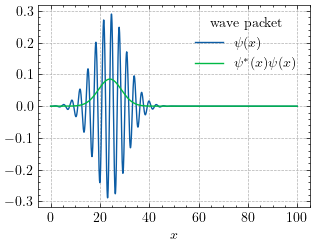

In [12]:
plt.clf()
plt.grid(ls="--")
plt.plot(x, wave.real, label=r'$\psi(x)$')
if show_density:
    density = (np.conjugate(wave) * wave).real
    plt.plot(x, density, label='$\psi^*(x)\psi(x)$')
plt.xlabel(r'$x$')
plt.legend(loc='best', title="wave packet")
plt.show()

In [13]:
t, psiList, rhoList = evolve(tfinal=30.0, nt=400)

C:\Users\Tom\anaconda3\envs\py310\lib\site-packages\matplotlib\animation.py:879: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


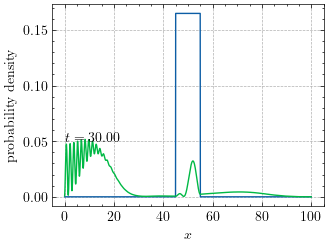

In [31]:
def update(i):
    line.set_data(x, rhoList[i])
    text.set_text(r'$t=%.2f$' % t[i])
    return line, text


potential = barrier(shape=peak_shape)

fig1, ax1 = plt.subplots()
plt.plot(x, potential * 0.08)
line, = plt.plot(x, rhoList[0])
text = plt.text(0, 0.05, '')
plt.grid(ls="--")

plt.ylabel('probability density')

plt.xlabel(r'$x$')
anim1 = FuncAnimation(fig1, update, frames=400, interval=100, blit=True)
anim1.save('o.mp4', fps=30, dpi=300)
plt.show()